In [360]:
%matplotlib inline

In [361]:
from dataclasses import dataclass
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.axes import Axes
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import learning_curve, ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

plt.rcParams["figure.figsize"] = (12, 5)
sns.set_theme()

In [362]:
def r2(y_true, y_pred):
    return r2_score(y_true, y_pred)


def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)


def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


def _plot_learning_curve(
        estimator,
        X,
        y,
        title='Learning Curves',
        axes=None,
        ylim=None,
        cv=ShuffleSplit(n_splits=5, test_size=0.2),
        n_jobs=None,
        train_sizes=np.linspace(0.1, 1.0, 5),
):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


def _plot_predict(x, y, predict):
    ax: Axes = sns.scatterplot(x=x, y=y)
    ax.plot(x, predict, color='magenta')

In [363]:
# объекты для хранения результатов и удобные обобщающие функции

@dataclass
class Score:
    r2: float
    mae: float
    rmse: float


@dataclass
class Data:
    X: Union[pd.DataFrame, pd.Series]
    X_train: Union[pd.DataFrame, pd.Series]
    X_test: Union[pd.DataFrame, pd.Series]
    y: pd.Series
    y_train: pd.Series
    y_test: pd.Series


@dataclass
class Predict:
    general: pd.Series
    train: pd.Series
    test: pd.Series


@dataclass
class Result:
    data: Data
    model: LinearRegression
    predict: Predict
    score_train: Score
    score_test: Score


def pair_regression(X, y, func=None) -> list[Result]:
    """Строит список парных моделей с каждым из признаков"""
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

    results = []
    for i in range(X.shape[1]):
        if func is None:
            x, x_train, x_test = X[[i]], X_train[[i]], X_test[[i]]
        else:
            x, x_train, x_test = func(X[[i]]), func(X_train[[i]]), func(X_test[[i]])

        data = Data(x, x_train, x_test, y, y_train, y_test)

        model = LinearRegression().fit(x_train, y_train)

        predict = Predict(model.predict(x), model.predict(x_train), model.predict(x_test))

        score_train = Score(r2(y_train, predict.train), mae(y_train, predict.train), rmse(y_train, predict.train))
        score_test = Score(r2(y_test, predict.test), mae(y_test, predict.test), rmse(y_test, predict.test))

        results.append(Result(data, model, predict, score_train, score_test))

    return results


In [364]:
def plot_learning_curve(res: Result):
    _plot_learning_curve(res.model, res.data.X_train, res.data.y_train)


def plot_predict(res: Result):
    _plot_predict(res.data.X.squeeze(), res.data.y.squeeze(), res.predict.general)


def show_score(score: Score):
    print(f'R^2: {score.r2:.4f}')
    print(f'MAE: {score.mae:.4f}')
    print(f'RMSE: {score.rmse:.4f}')
    print('-' * 20)


# Основные задания

In [365]:
X = pd.read_csv('data/23_x.csv', header=None)
y = pd.read_csv('data/23_y.csv', header=None)

In [366]:
X.shape, X.describe()

((374, 4),
                 0           1           2           3
 count  374.000000  374.000000  374.000000  374.000000
 mean     0.022809    0.052122   -0.047351   -0.009339
 std      1.060930    0.987249    0.930535    0.963406
 min     -3.517654   -2.243863   -2.733029   -2.672787
 25%     -0.672719   -0.638758   -0.700923   -0.710718
 50%     -0.032406    0.026829   -0.024443    0.028487
 75%      0.631828    0.639133    0.544270    0.707798
 max      3.277544    3.130895    3.270491    2.567770)

In [367]:
X.corr()

,0,1,2,3
0,1.000000,-0.058593,-0.097857,-0.014398
1,-0.058593,1.000000,0.121479,-0.014886
2,-0.097857,0.121479,1.000000,-0.045077
3,-0.014398,-0.014886,-0.045077,1.000000


Признаки слабо коррелируют между собой

## Парная регрессия

In [368]:
results = pair_regression(X, y)

### Признак #1

In [369]:
res_0 = results[0]

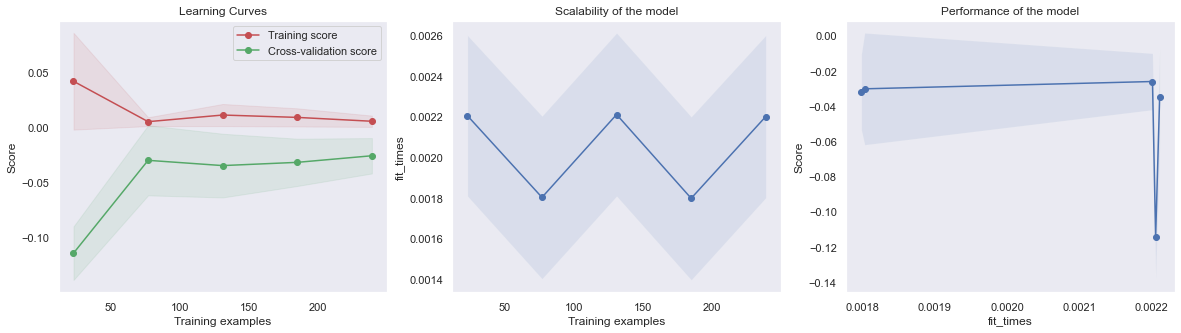

In [370]:
plot_learning_curve(res_0)

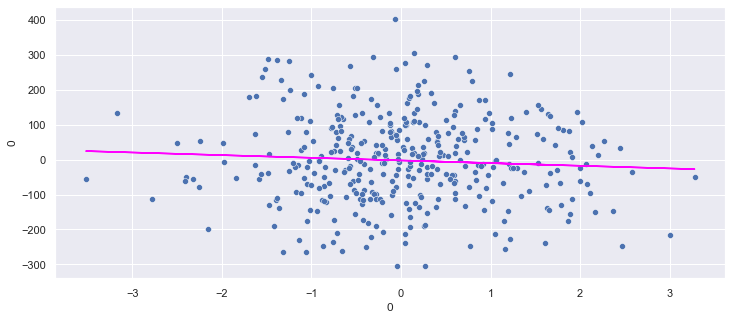

In [371]:
plot_predict(res_0)

In [372]:
show_score(res_0.score_test)
show_score(res_0.score_train)

R^2: -0.0349
MAE: 102.7363
RMSE: 128.3013
--------------------
R^2: 0.0044
MAE: 97.8076
RMSE: 123.4749
--------------------


### Признак #2

In [373]:
res_1 = results[1]

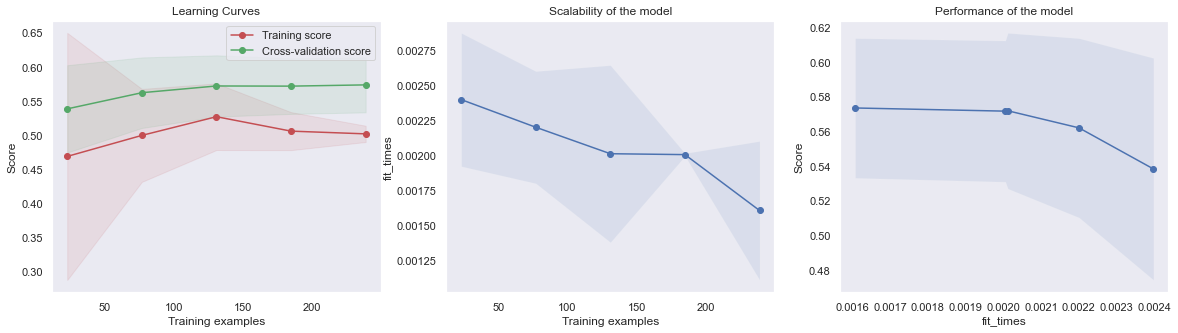

In [374]:
plot_learning_curve(res_1)

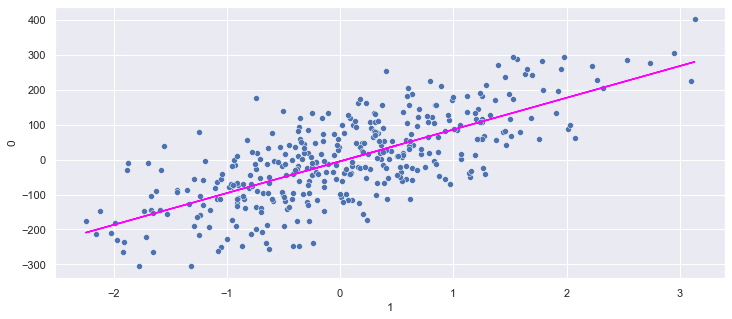

In [375]:
plot_predict(res_1)

In [376]:
show_score(res_1.score_test)
show_score(res_1.score_train)

R^2: 0.5935
MAE: 63.4961
RMSE: 80.4116
--------------------
R^2: 0.5191
MAE: 69.6459
RMSE: 85.8139
--------------------


### Признак #3

In [377]:
res_2 = results[2]

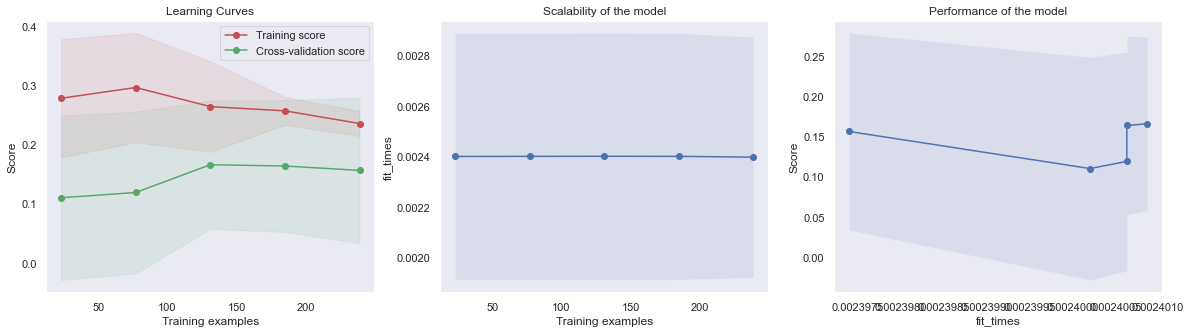

In [378]:
plot_learning_curve(res_2)

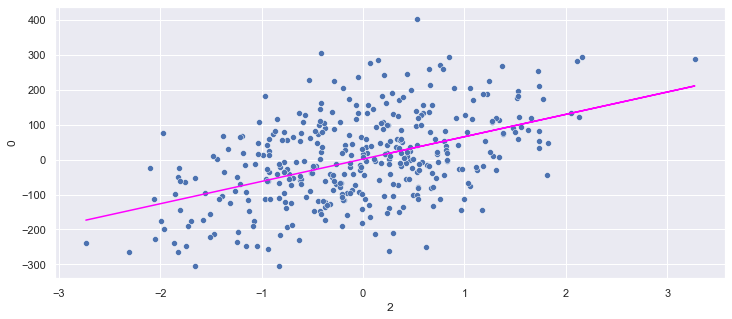

In [379]:
plot_predict(res_2)

In [380]:
show_score(res_2.score_test)
show_score(res_2.score_train)

R^2: 0.2494
MAE: 91.6075
RMSE: 109.2704
--------------------
R^2: 0.2304
MAE: 85.1684
RMSE: 108.5601
--------------------


### Признак #4

In [381]:
res_3 = results[3]

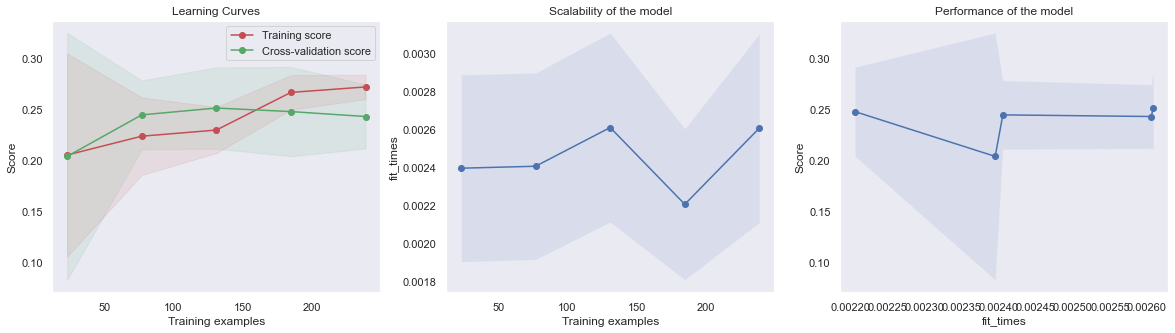

In [382]:
plot_learning_curve(res_3)

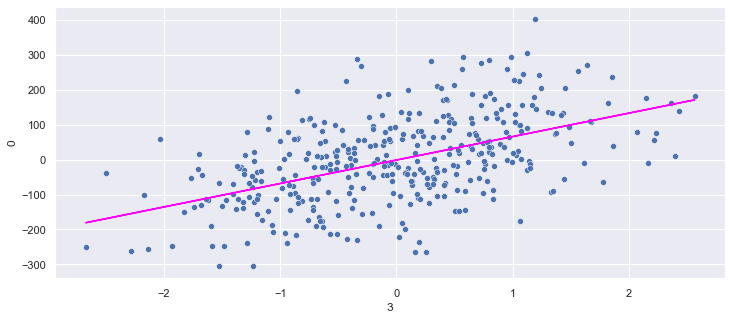

In [383]:
plot_predict(res_3)

In [384]:
show_score(res_3.score_test)
show_score(res_3.score_train)

R^2: 0.1952
MAE: 91.3838
RMSE: 113.1421
--------------------
R^2: 0.2725
MAE: 83.7807
RMSE: 105.5470
--------------------


## Множественная регрессия

In [385]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [386]:
mult_model = LinearRegression().fit(X_train, y_train)

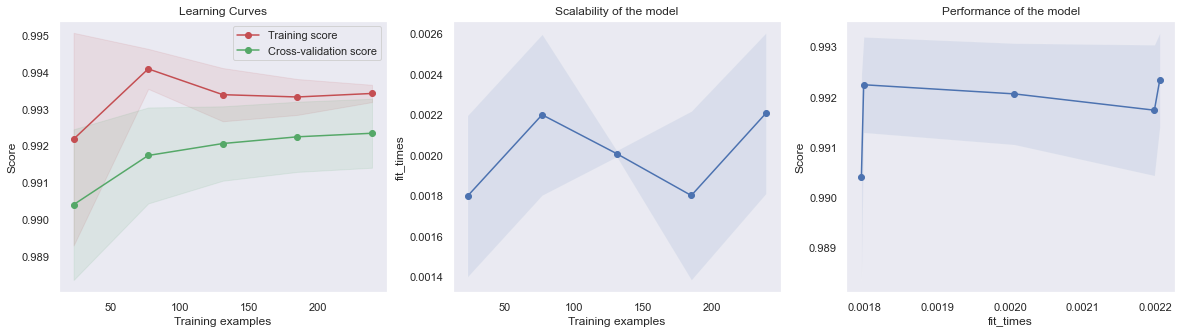

In [387]:
_ = _plot_learning_curve(mult_model, X_train, y_train)

In [388]:
mult_predict_test = mult_model.predict(X_test)
mult_predict_train = mult_model.predict(X_train)
print(f'R^2: {r2(y_test, mult_predict_test):.4f}')
print(f'MAE: {mae(y_test, mult_predict_test):.4f}')
print(f'RMSE: {rmse(y_test, mult_predict_test):.4f}')
print('-' * 20)
print(f'R^2: {r2(y_train, mult_predict_train):.4f}')
print(f'MAE: {mae(y_train, mult_predict_train):.4f}')
print(f'RMSE: {rmse(y_train, mult_predict_train):.4f}')

R^2: 0.9892
MAE: 9.4764
RMSE: 11.5696
--------------------
R^2: 0.9933
MAE: 8.3185
RMSE: 10.4445


R^2 близок к 1 - модель качественная
Значения ошибок меньше чем в парных моделях - модель качественная
оценки близки и на обучающих и на тестовых данных

## Полиномиальная регрессия

In [389]:
pf_2 = PolynomialFeatures(degree=2)
pf_3 = PolynomialFeatures(degree=3)
pf_10 = PolynomialFeatures(degree=10)

In [390]:
results_pf_2 = pair_regression(X, y, func=pf_2.fit_transform)
results_pf_3 = pair_regression(X, y, func=pf_3.fit_transform)
results_pf_10 = pair_regression(X, y, func=pf_10.fit_transform)

In [391]:
pf_agg = {
    'pf_2': results_pf_2,
    'pf_3': results_pf_3,
    'pf_10': results_pf_10
}
for k, v in pf_agg.items():
    print(f'{k.upper():*^20}')
    for i, res in enumerate(v, start=1):
        print(f'{i:-^20}')
        show_score(res.score_test)
        show_score(res.score_train)
        print()
    print('*' * 20)
# модель в целом значима

********PF_2********
---------1----------
R^2: 0.0058
MAE: 96.8916
RMSE: 124.5370
--------------------
R^2: 0.0076
MAE: 98.3463
RMSE: 123.9106
--------------------

---------2----------
R^2: 0.5182
MAE: 65.7513
RMSE: 86.6916
--------------------
R^2: 0.5437
MAE: 68.7438
RMSE: 84.0226
--------------------

---------3----------
R^2: 0.1720
MAE: 88.7131
RMSE: 113.6468
--------------------
R^2: 0.2541
MAE: 86.1552
RMSE: 107.4283
--------------------

---------4----------
R^2: 0.3305
MAE: 82.8273
RMSE: 102.1946
--------------------
R^2: 0.2423
MAE: 86.0486
RMSE: 108.2734
--------------------

********************
********PF_3********
---------1----------
R^2: -0.0274
MAE: 96.5684
RMSE: 121.1100
--------------------
R^2: 0.0184
MAE: 99.0319
RMSE: 124.4510
--------------------

---------2----------
R^2: 0.5617
MAE: 65.2253
RMSE: 79.1016
--------------------
R^2: 0.5316
MAE: 69.0731
RMSE: 85.9697
--------------------

---------3----------
R^2: 0.2827
MAE: 81.3062
RMSE: 101.1956
---------------

## Сводная таблица метрик

In [392]:
def get_result_scores(result: Result):
    return [result.score_test.r2, result.score_test.mae, result.score_test.rmse,
            result.score_train.r2, result.score_train.mae, result.score_train.rmse]

In [393]:
score_df = pd.DataFrame(
    {
        'pair_0': get_result_scores(results[0]),
        'pair_1': get_result_scores(results[1]),
        'pair_2': get_result_scores(results[2]),
        'pair_3': get_result_scores(results[3]),
        'mult': [r2(y_test, mult_predict_test), mae(y_test, mult_predict_test), rmse(y_test, mult_predict_test),
                 r2(y_train, mult_predict_train), mae(y_train, mult_predict_train), rmse(y_train, mult_predict_train)],
        'pf_2_0': get_result_scores(results_pf_2[0]),
        'pf_2_1': get_result_scores(results_pf_2[1]),
        'pf_2_2': get_result_scores(results_pf_2[2]),
        'pf_2_3': get_result_scores(results_pf_2[3]),
        'pf_3_0': get_result_scores(results_pf_3[0]),
        'pf_3_1': get_result_scores(results_pf_3[1]),
        'pf_3_2': get_result_scores(results_pf_3[2]),
        'pf_3_3': get_result_scores(results_pf_3[3]),
        'pf_10_0': get_result_scores(results_pf_10[0]),
        'pf_10_1': get_result_scores(results_pf_10[1]),
        'pf_10_2': get_result_scores(results_pf_10[2]),
        'pf_10_3': get_result_scores(results_pf_10[3]),
    },
    index=pd.MultiIndex.from_tuples([
        ('test', 'R^2'), ('test', 'MAE'), ('test', 'RMSE'),
        ('train', 'R^2'), ('train', 'MAE'), ('train', 'RMSE')
    ]),
)

**pair_n** - парная модель с n-ым признаком
**mult** - множественная модель с 4-мя признаками
**pf_i_n** - полиномиальная модель i-ой степени с n-ым признаком

In [394]:
score_df

pair_0     pair_1      pair_2      pair_3       mult  \
test  R^2    -0.034852   0.593507    0.249378    0.195243   0.989214   
      MAE   102.736291  63.496098   91.607536   91.383811   9.476404   
      RMSE  128.301291  80.411578  109.270378  113.142140  11.569581   
train R^2     0.004399   0.519113    0.230394    0.272523   0.993289   
      MAE    97.807601  69.645921   85.168429   83.780672   8.318462   
      RMSE  123.474927  85.813890  108.560095  105.546967  10.444504   

                pf_2_0     pf_2_1      pf_2_2      pf_2_3      pf_3_0  \
test  R^2     0.005769   0.518224    0.172049    0.330507   -0.027420   
      MAE    96.891578  65.751340   88.713150   82.827276   96.568412   
      RMSE  124.536987  86.691635  113.646781  102.194574  121.109993   
train R^2     0.007621   0.543697    0.254070    0.242287    0.018358   
      MAE    98.346309  68.743762   86.155171   86.048579   99.031912   
      RMSE  123.910575  84.022596  107.428291  108.273422  124.450983   

               pf_3_1      pf_3_2      pf_3_3     pf_10_0    pf_10_1  \
test  R^2    0.561713    0.282682    0.160410   -0.014993   0.524593   
      MAE   65.225340   81.306232   85.593648   96.715007  68.836041   
      RMSE  79.101597  101.195645  109.481223  119.229590  81.599080   
train R^2    0.531567    0.235598    0.282336    0.044710   0.538159   
      MAE   69.073111   87.411109   85.943784   96.897767  68.143303   
      RMSE  85.969672  109.820300  106.410007  123.116743  85.604336   

               pf_10_2     pf_10_3  
test  R^2     0.007773   -0.949898  
      MAE    93.104939  104.101808  
      RMSE  117.884877  165.256489  
train R^2     0.283864    0.299564  
      MAE    84.200111   81.499385  
      RMSE  106.597555  105.422641

In [395]:
score_df.to_excel('out/score_table.xlsx')

## Big Data

Измерение времени обучения на большем объеме данных

In [396]:
# не нашел x в датасетах, построил зависимость самого от себя через полиномиальную регрессию
y_ = pd.read_csv('data/1_y.csv', header=None)
x_ = PolynomialFeatures(degree=3).fit_transform(y_)
y_.shape, x_.shape

((98041, 1), (98041, 4))

In [397]:
X_train, X_test, y_train, y_test = train_test_split(x_, y_, train_size=0.8)

In [ ]:
%timeit LinearRegression().fit(X_train, y_train)  # 4 признака

In [ ]:
%timeit LinearRegression().fit(X_train[:, 1].reshape(-1, 1), y_train)  # 1 признак

Измерение времени обучения на меньшем объеме данных

In [400]:
X.shape, y.shape

((374, 4), (374, 1))

In [401]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [402]:
%timeit LinearRegression().fit(X_train, y_train)  # 4 признака

1.54 ms ± 39.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [403]:
%timeit LinearRegression().fit(X_train[[0]], y_train)  # 1 признак

1.82 ms ± 18.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Время обучения модели зависит и от объема данных и от количества признаков.
**Чем больше объем данных и чем больше кол-во признаков, тем больше времени занимает обучение модели**